In [1]:
# To generate GIFs
%pip install imageio
%pip install git+https://github.com/tensorflow/docs


[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/tensorflow/docs to /private/var/folders/p_/j8lh2l8d3r3dwh95sx4bxlt40000gn/T/pip-req-build-p5527vt1
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/p_/j8lh2l8d3r3dwh95sx4bxlt40000gn/T/pip-req-build-p5527vt1
  Resolved https://github.com/tensorflow/docs to commit 6680535155460f7eb0d2d615b9749a0cf721d4ec
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

2024-07-12 12:27:09.067044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5 # Normalizes images to [-1,1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [20]:
# Making generator
def generator_model():

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128,  (5,5), strides = (1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64,  (5,5), strides = (2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5,5), strides =(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model





/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


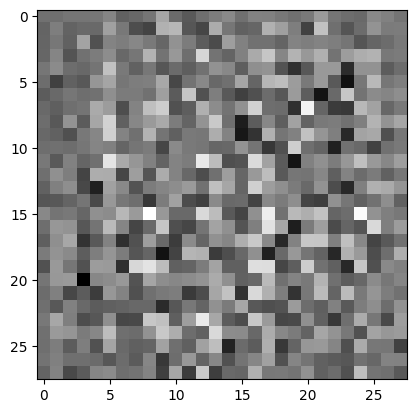

In [33]:
generator = generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0,:,:,0], cmap= 'gray')

In [49]:
def discriminator_model() :
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [51]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00393217]], shape=(1, 1), dtype=float32)


In [52]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss+fake_loss

    return total_loss

In [55]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [54]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [59]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [64]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [65]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

In [66]:
train(train_dataset, EPOCHS)

2024-07-12 13:41:59.882628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [64] vs. [0]
	 [[{{node adam/Sub_35}}]]


InvalidArgumentError: Graph execution error:

Detected at node adam/Sub_35 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/rish/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/p_/j8lh2l8d3r3dwh95sx4bxlt40000gn/T/ipykernel_12104/2228458018.py", line 1, in <module>

  File "/var/folders/p_/j8lh2l8d3r3dwh95sx4bxlt40000gn/T/ipykernel_12104/218034967.py", line 6, in train

  File "/var/folders/p_/j8lh2l8d3r3dwh95sx4bxlt40000gn/T/ipykernel_12104/3248131820.py", line 19, in train_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 282, in apply_gradients

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 351, in apply

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 405, in _backend_apply_gradients

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 119, in _backend_update_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 135, in _distributed_tf_update_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 132, in apply_grad_to_update_var

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/adam.py", line 138, in update_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 5437, in subtract

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/sparse.py", line 493, in sparse_wrapper

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 346, in subtract

Incompatible shapes: [64] vs. [0]
	 [[{{node adam/Sub_35}}]] [Op:__inference_train_step_9273]